# Feature Generation

In [53]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('../input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

In [127]:
# Defining some functions that will help us test our encodings
import lightgbm as lgb
from sklearn import metrics

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=30, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

In [128]:
# Training a model on the baseline data
train, valid, _ = get_data_splits(baseline_data)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7480


# Interactions

One of the easiest ways to create new features is by combining categorical variables. For example, if one record has the country `"CA"` and category `"Music"`, you can create a new value `"CA_Music"`. This is a new categorical feature that can provide information about correlations between categorical variables. This type of feature is typically called an **interaction**. In general, you would build interaction features from all pairs of categorical features. You can go further and make interactions from three or more features as well.



In [129]:
interactions = ks['category'] + "_" + ks['country']
print(interactions.head(10))

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
5       Restaurants_US
6              Food_US
7            Drinks_US
8    Product Design_US
9       Documentary_US
dtype: object


Then, label encode the interaction feature and add it to our data.

In [130]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interaction))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


In [132]:
# Training a model on the baseline data
train, valid, _ = get_data_splits(data_interaction)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7475


Adding this interaction increased the score from 0.7467 to 0.7471.

# Generating numerical features

You can provide more information for your model by creating new features from the data itself. For example, you can calculate the number of total projects in the last week and the duration of the fundraising. The features you can create are different for every dataset so it takes a bit of creativity and experimentation.

First up I'll show you how to count the number of projects launched in the preceeding week for each record.

In [133]:
launched = pd.Series(ks.index, index=ks.launched).sort_index()
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
dtype: int64

launched
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
1970-01-01 01:00:00     7.0
2009-04-21 21:02:48     1.0
2009-04-23 00:07:53     2.0
2009-04-24 21:52:03     3.0
2009-04-25 17:36:21     4.0
2009-04-27 14:10:39     5.0
2009-04-28 13:55:41     6.0
2009-04-29 02:04:21     6.0
2009-04-29 02:58:50     7.0
2009-04-29 04:37:37     8.0
2009-04-29 05:26:32     9.0
2009-04-29 06:43:44    10.0
2009-04-29 13:52:03    11.0
2009-04-29 22:08:13    12.0
dtype: float64


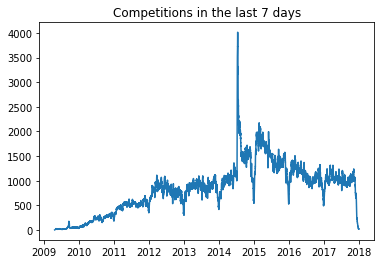

In [134]:
count_7_days = launched.rolling('7d').count()
print(last_week_count.head(20))
# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Competitions in the last 7 days");

In [135]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

In [136]:
# Training a model on the baseline data

train, valid, _ = get_data_splits(baseline_data.assign(count_7_days=count_7_days))
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7456


In [155]:
df

,category,launched
94579,Theater,1970-01-01 01:00:00
319002,Publishing,1970-01-01 01:00:00
247913,Music,1970-01-01 01:00:00
48147,Art,1970-01-01 01:00:00
75397,Film & Video,1970-01-01 01:00:00
2842,Film & Video,1970-01-01 01:00:00
273779,Design,1970-01-01 01:00:00
169268,Fashion,2009-04-21 21:02:48
322000,Shorts,2009-04-23 00:07:53
138572,Illustration,2009-04-24 21:52:03


In [160]:
df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').diff()['launched']

In [163]:
timedeltas

94579                    NaT
319002                   NaT
247913                   NaT
48147                    NaT
75397                    NaT
2842         0 days 00:00:00
273779                   NaT
169268                   NaT
322000                   NaT
138572                   NaT
325391                   NaT
122662       5 days 17:07:51
213711                   NaT
345606       6 days 01:56:28
235255                   NaT
98954    14363 days 03:37:37
342226                   NaT
275091                   NaT
284115                   NaT
32898                    NaT
153308       4 days 05:34:54
19561    14364 days 00:32:55
225159   14364 days 06:14:06
28960                    NaT
59959        1 days 17:45:06
157553       0 days 00:00:39
359589       0 days 06:42:57
113932                   NaT
262521                   NaT
350900                   NaT
                 ...        
139781      13 days 08:25:41
240149       9 days 04:23:12
70996        5 days 17:39:55
365298      21

# Transforming numerical features

In [137]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

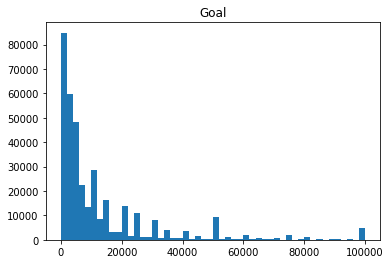

In [138]:
plt.hist(ks.goal, range=(0, 100000), bins=50);
plt.title('Goal');

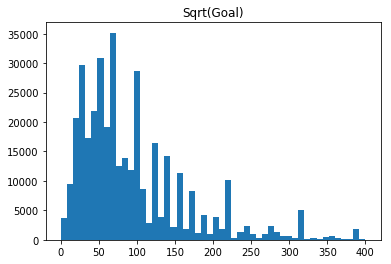

In [139]:
plt.hist(np.sqrt(ks.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

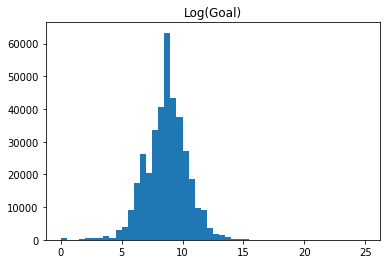

In [140]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

In [141]:
transformed = baseline_data.copy()
transformed['goal'] = np.log(ks.goal)

In [142]:
# Training a model on the baseline data
train, valid, _ = get_data_splits(transformed)
bst = train_model(train, valid)

Training model!
Validation AUC score: 0.7461


In [143]:
transformed

,goal,hour,day,month,year,outcome,category,currency,country
0,6.907755,12,11,8,2015,0,108,5,9
1,10.308953,4,2,9,2017,0,93,13,22
2,10.714418,0,12,1,2013,0,93,13,22
3,8.517193,3,17,3,2012,0,90,13,22
4,9.878170,8,4,7,2015,0,55,13,22
5,10.819778,13,26,2,2016,1,123,13,22
6,6.907755,18,1,12,2014,1,58,13,22
7,10.126631,20,1,2,2016,0,41,13,22
8,11.736069,18,24,4,2014,0,113,13,22
9,11.082143,21,11,7,2014,0,39,13,22
